In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from delphi.utils import constants as consts
from delphi import oracle
from delphi import train
from delphi.utils import defaults
import datetime

# Store Information, etc

In [2]:
STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
STORE_TABLE_NAME = 'multi_log_reg'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/LogisticRegression/5b31e98e-45d5-4775-b2ac-635e2e34fd3f


# Standard Gumbel Distribution

(array([  4.,   4.,   5.,  23.,  27.,  63.,  69.,  91., 153., 185., 226.,
        261., 283., 326., 352., 395., 386., 399., 426., 391., 399., 388.,
        414., 367., 333., 337., 313., 319., 297., 260., 238., 212., 201.,
        201., 165., 137., 126., 115., 104., 101.,  97.,  97.,  76.,  65.,
         59.,  46.,  48.,  43.,  35.,  41.,  46.,  29.,  25.,  24.,  23.,
         12.,  15.,  12.,  10.,  11.,   9.,   9.,  12.,   6.,   5.,   5.,
          2.,   4.,   3.,   1.,   5.,   7.,   2.,   2.,   4.,   1.,   2.,
          3.,   1.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.1231728 , -2.010586  , -1.8979993 , -1.7854125 , -1.6728258 ,
        -1.5602391 , -1.4476523 , -1.3350655 , -1.2224787 , -1.109892  ,
        -0.9973053 , -0.88471854, -0.7721318 , -0.65954506, -0.5469583 ,
        -0.43437156, -0.32178482, -0.20919807, -0.09661133,  0.01597542,
         0.12856217,  0.24

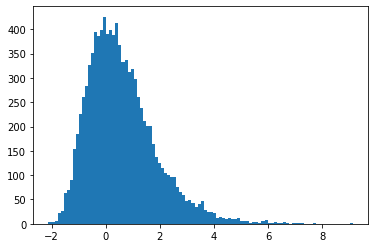

In [2]:
G = Gumbel(0, 1)

samples = G.sample(ch.Size([10000, 1])).T
plt.hist(samples, bins=100)

## Default Experiment Parameters

In [3]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'custom_lr_multiplier': consts.COSINE,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 1, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
})

# args = defaults.check_and_fill_args(train_kwargs, defaults.TRAINING_ARGS, CIFAR)

# Multinomial Logistic Regression

In [4]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
M = MultivariateNormal(ch.zeros(args.IN_FEATURES), ch.eye(args.IN_FEATURES)/args.IN_FEATURES)
X = M.sample(ch.Size([args.samples]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[ 0.3512],
        [-0.3677]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([-0.0230,  0.5621], requires_grad=True)


# Untruncated Experiment

In [14]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # retain logits of kth class
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        out = noised.sum(dim=0) / noised.size(0)
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        return grad / pred.size(0), -grad / pred.size(0)

In [15]:
emp_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

In [16]:
ds = TensorDataset(X, y)
loader = DataLoader(ds, num_workers=args.num_workers)
criterion = GumbelCE.apply
optimizer = ch.optim.SGD(emp_multi_log_reg.parameters(), lr=1e-2)

In [18]:
# for epoch in range(args.epochs): 
for X, y in loader: 
    print("X: {}".format(X))
    print("y: {}".format(y))
    pred = emp_multi_log_reg(X)
    loss = criterion(pred,  y)
    loss.backward()
    optimizer.step()       
        

X: tensor([[-0.9555]])
y: tensor([1])


In [209]:
print("pred: {}".format(pred))

pred: tensor([[0., 1.]], grad_fn=<AddBackward0>)


In [7]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 8/8 [00:00<00:00, 234.15it/s]

,delphi_cos,mle_cos,alpha,C,exp_id
0,0.755610,0.811039,0.5251,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
1,0.503841,-0.020497,0.5069,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
2,0.987580,0.858828,0.5075,-1.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
3,0.904469,-0.610786,0.5042,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
4,0.932691,0.932682,0.5145,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078


# All Trials

In [214]:
loss = ch.nn.CrossEntropyLoss()
in_ = ch.randn(3, 5, requires_grad=True)
targ = ch.empty(3, dtype=ch.long).random_(5)
output = loss(in_, targ)
output.backward()

all trials:


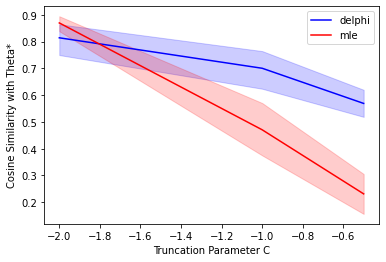

In [8]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

tensor(1.6816, grad_fn=<NllLossBackward>)

In [232]:
in_

tensor([[ 1.7647, -0.4050,  0.5992, -1.1123, -0.1541],
        [ 1.0274, -1.0257, -0.4407,  0.2456,  0.0607],
        [-0.0506,  2.1215,  1.7285, -0.7172, -1.3141]], requires_grad=True)

In [233]:
targ

tensor([1, 2, 4])

In [239]:
ch.index_select(in_, 0, targ.unsqueeze())

tensor([-0.4050,  0.5992, -0.1541], grad_fn=<IndexSelectBackward>)

tensor([ 1.7647, -0.4050,  0.5992, -1.1123, -0.1541], grad_fn=<SelectBackward>)